# IBM Coursera Advanced Data Science - Capstone Project - Stéphane Degeye
## Image Captioning based on visual Attention

The purpose of this project is, from a real-life situation (represented by a photo) to predict the captions which makes it possible to describe this situation as well as possible. The objective is to use for that a set of photos/captions specific to the field of my company (Energy) but this is out of scope for this project. We will instead use the famous COCO dataset

More information on COCO dataset can be found here :

Website : http://cocodataset.org/#home

Research Paper : https://arxiv.org/abs/1405.0312

Some helper functions in this notebook come from TensorFlow Website : https://www.tensorflow.org/tutorials/text/image_captioning


## 0. Import Librairies

In [3]:
!pip uninstall tensorflow --yes

Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\ML\Scripts\pip-script.py", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip._internal.cli.main'


In [4]:
!pip install tensorflow==2.1.0

Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\ML\Scripts\pip-script.py", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip._internal.cli.main'


In [5]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tqdm import tqdm

import re
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import imageio
from IPython.display import SVG
from nltk.translate.bleu_score import sentence_bleu

## 1 Extraction - Transform - Load
### 1.1 COCO Dataset (image/captions pairs)

In [7]:
# Target Files and Folders parameters
current_folder = os.path.abspath('.')

# Images Target Location
image_folder = '/train2017/'
image_full_path = current_folder + image_folder

# Annotation Target Location 
annotation_folder = '/annotations/'
annotation_file = 'captions_train2017.json'
annotation_full_path = current_folder + annotation_folder + annotation_file

# Show full path
print ('image_full_path is {}'.format(image_full_path))
print ('annotation_full_path is {}'.format(annotation_full_path))

image_full_path is C:\Users\Admin\Documents\STEPH\50_Cursus\Coursera\07 Advanced Data Science with IBM Specialization\Course 04 - Advanced Data Science Capstone\Projet\Common Objects in Context/train2017/
annotation_full_path is C:\Users\Admin\Documents\STEPH\50_Cursus\Coursera\07 Advanced Data Science with IBM Specialization\Course 04 - Advanced Data Science Capstone\Projet\Common Objects in Context/annotations/captions_train2017.json


In [8]:
# Download annotation files (captions)
if not os.path.exists(current_folder + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
  os.remove(annotation_zip)

# Download image files
if not os.path.exists(current_folder + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  os.remove(image_zip)

In [9]:
# Read the json file
with open(annotation_full_path, 'r') as f:
    annotations = json.load(f)

# Vectors to store results
all_captions = []
all_img_name_vector = []

# Extraction of relevant data from annotations and addition of caption delimiters
for annot in annotations['annotations']:

    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = image_full_path + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffling
train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)

# Reduction of Dataset for performance reason
num_examples = 25000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

### 1.2 Data Vizualization

In [10]:
# Helper Function to display image/captions
def print_image_with_captions (image, captions):
            
    pic = imageio.imread(image)
    fig = plt.figure(figsize = (8,10))
    ax = fig.add_subplot(111)
    ax.set_xlabel(captions)
    plt.imshow(pic)
    plt.show

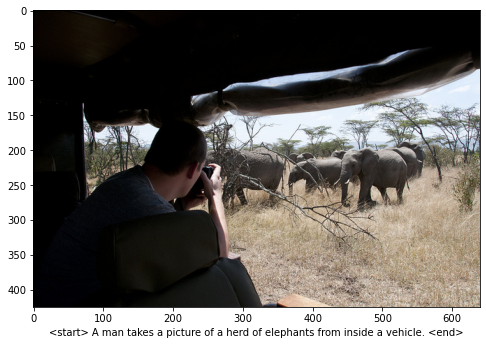

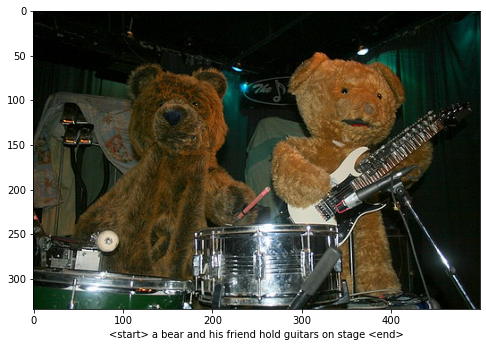

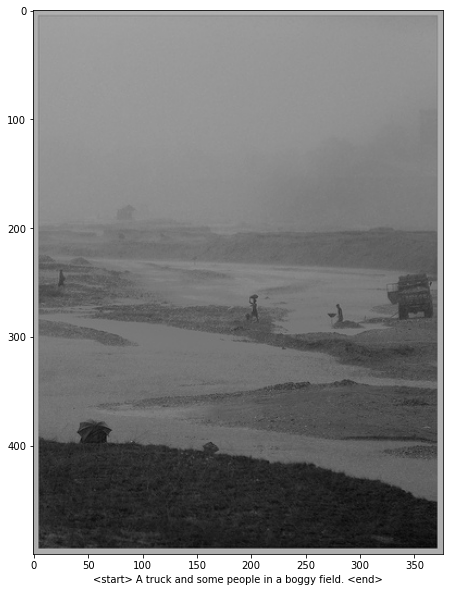

In [11]:
# Display few samples of images with their caption 
for x in range (100,103):
    print_image_with_captions (img_name_vector[x],train_captions[x])

### 1.3 Image Preprocessing/Transfer Learning (InceptionV3)

For Transfer Learning I will reuse the `InceptionV3` Model (created by Google and initially used as module for GoogLeNet).
InceptionV3 has been trained on the huge `ImageNet` dataset (1,331,167 images).

More info on InceptionV3 can be found here : https://cloud.google.com/tpu/docs/inception-v3-advanced

More info on ImageNet can be found here : http://www.image-net.org/papers/imagenet_cvpr09.pdf


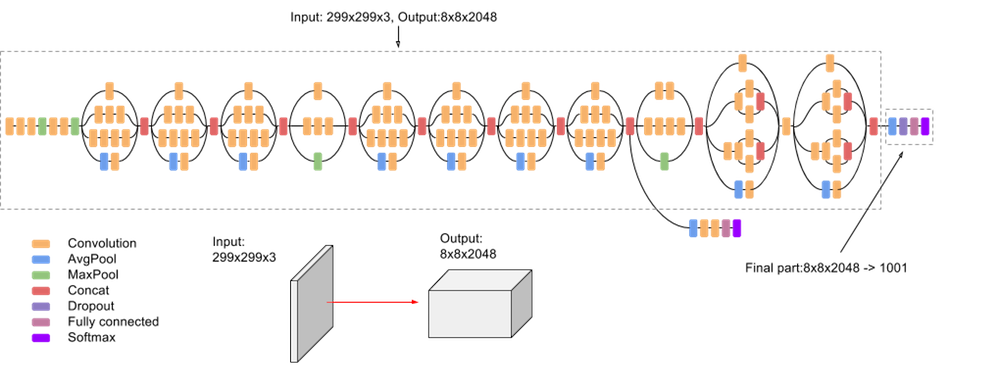

In [12]:
# Preprocessing for matching with Inceptionv3 Model Input
# Normalization (pixels conversion to a range between [-1,1] is performed by the preprocess_input() function)
def load_image(image_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

In [13]:
# Reusing of InceptionV3 Model without it's Top Layer to create our model
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [14]:
# Create Dataset from Files list
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Create Datasetbatch object by mapping load_image() function
image_dataset = image_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [ ]:
# Features Extraction and saving to disk
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
   
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        
        np.save(path_of_feature, bf.numpy())

124it [6:30:00, 485.44s/it]

### 1.3 Caption Preprocessing

In [ ]:
# Longest Legend
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
# "Out Of Vocabulary token" is <oov>
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<oov>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Tokenizing step
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Padding step
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# max_length used to store the attention weights
max_length = calc_max_length(train_seqs)

### 1.4 Final Dataset 
#### - Training/Test Splitting
#### - (Image features/Caption Vector Pairs)

A very practical functionnality to achieve that is to use (tf.data) functions.
In this way, the process can be implemented as a sort of PIPELINE

In [ ]:
# training/validation set are 80/20 percent of full initial dataset
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

print(img_name_train[1])
print(cap_train[1])

print(img_name_val[1])
print(cap_val[1])

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 2 Models

In [ ]:
# Feel free to change these parameters according to your system's configuration
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

### 2.1 Encoder (CNN)

The Encoder passes images features (saved to disk in a previous step) to a Fully Connected layer (FC)
Then, a Relu() activation function is applied.
Our data is ready to be injected as input to our decoder.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### 2.2 Decoder (RNN)

In an usual RNN, RNN predicts the next word of a sentence based only on the the previous predicted word (and of course by taking into consideration the context of the sentence). In our case (to find captions related to a given image), this process is not well suited.

Image features (a visual attention) is also very important to achieve this process
For reliability, you have to divide the image into different parts. 

The encoder has already divided the image and prepare the structure to be used as input by the decoder.
so RNN, will be trained by using a combination of images features/RNN features.

Visual attention is one of the major advances in deep learning today.
The model used is based on Dzmitry Bahdanau.

More info can be found here :

https://arxiv.org/abs/1502.03044

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### 2.3 Loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  #restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

### 2.4 Model Training 

It is important to specify that the models (Attention & RNN) are `trained together` except for the phase of features extraction by CNN (pre-processing)

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  hidden = decoder.reset_state(batch_size=target.shape[0])

   
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
 

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
     

      for i in range(1, target.shape[1]):
          
        # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
         
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing (by giving the next word to RNN)
          dec_input = tf.expand_dims(target[:, i], 1)
        
            
  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
       
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
# Loss evolution in time
plt.plot(loss_plot)
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.title = 'Loss Plot'
plt.show()

### 2.5 Evaluation

`BLEU` (bilingual evaluation understudy) Score metrics is used for Model Evaluation.

This score indicates how similar the candidate text (captions prediction) is to the reference texts (real prediction)
(Values closer to 1 representing more similar texts). 

The BLEU score was proposed by Kishore Papineni, et al (2002)

More info on BLEU can be found here : https://www.aclweb.org/anthology/P02-1040.pdf


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
        
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# BLEU Score average calculation on Validation Set

# Init average
average_score = 0

# Range = 25000 * 0.2 = 5000
for i in range (1,5000):
    
    image = img_name_val[i]
    real_caption = ' '.join([tokenizer.index_word[j] for j in cap_val[i] if j not in [0]])
    
    result, attention_plot = evaluate(image)
      
    # Vectors Splitting and delimiters removing
    real_caption_list = real_caption.split()
    real_caption_list = real_caption_list [1:-1]
    
    result_list = result[:-1]
     
    score = sentence_bleu(real_caption_list,result_list)
    average_score = (average_score + score) / i

print ('Average Score is {}'.format(average_score))

In [ ]:
# captions prediction on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))

plot_attention(image, result, attention_plot)

In [ ]:
# Validation on TensorFlow example image
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))

plot_attention(image_path, result, attention_plot)

# opening the image
Image.open(image_path)